<a href="https://colab.research.google.com/github/InesAgudoMartin/APRENDIZAJE_AUTOMATICO_23_24/blob/main/LAB02_E2_GRUPO%5B3%5DV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PARTE 2

##PREPARACIÓN DATOS

In [ ]:
!pip install ydata-profiling # Installs the ydata-profiling package, which includes pandas_profiling


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
data_file_path = 'firefighters_operations_madrid.csv'

data = pd.read_csv(data_file_path,  sep=';')

In [ ]:
# Descripción de cada atributo

profile = ProfileReport(
    data,
    title="firefighters",
    html={'style':{'full_width':True}},
    sort= None)

profile.to_file(output_file = 'firefighters_eda.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 87.30it/s]


In [ ]:
# Filtrar filas duplicadas basadas en la combinación de estas columnas

duplicated_inst = data[data.duplicated(subset=["year", "month", "district"], keep=False)]

# Visualizo
print(duplicated_inst.sort_values(by=["year", "month", "district"]).head(20))

data.drop_duplicates(subset=["year", "month", "district"], keep='first', inplace=True)


In [ ]:
# valores por año y valores de risk faltantes por año
value_years = data['year'].value_counts()
missing_years = data[data['risk'].isnull()]['year'].value_counts()

print('Valores por año', value_years)
print('Faltantes por año', missing_years)

In [ ]:
# Eliminar los valores del 2024 a los que les falta el riesgo
data.dropna(subset=['risk'], inplace=True)

In [ ]:
# Mostrar los valores únicos en la columna 'month'
print(data['month'].unique())

In [ ]:
# Reemplazar nombres de meses para estandarización
data['month'].replace(
    ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
    inplace=True
)

In [ ]:
# Función para categorizar una columna según umbrales dados
def categorize_column(column, none_max, low_max, medium_max):
    categories = []
    for value in column:
        if value <= none_max:
            categories.append('None_' + column.name)
        elif value <= low_max:
            categories.append('Low_' + column.name)
        elif value <= medium_max:
            categories.append('Medium_' + column.name)
        else:
            categories.append('High_' + column.name)
    return categories


# Aplicar la categorización a varias columnas del DataFrame
data["fires_category"] = categorize_column(data["fires"], 0, 4, 10)
data["construction_damages_category"] = categorize_column(data["construction_damages"], 0, 4, 10)
data["rescues_and_savings_category"] = categorize_column(data["rescues_and_savings"], 0, 4, 10)
data["water_damages_category"] = categorize_column(data["water_damages"], 0, 4, 10)
data["various_incidents_category"] = categorize_column(data["various_incidents"], 0, 4, 10)
data["non_intervention_calls_category"] = categorize_column(data["non_intervention_calls"], 0, 4, 10)
data["various_services_category"] = categorize_column(data["various_services"], 0, 4, 10)
data["risk_category"] = categorize_column(data["risk"], 0, 10, 100)

In [ ]:
# Creación de la lista de transacciones
data_transactions = data.drop(columns=['fires', 'construction_damages', 'rescues_and_savings',
                                       'water_damages', 'various_incidents', 'non_intervention_calls',
                                       'various_services', 'risk'], inplace=False)

data_transactions['year'] = data_transactions['year'].astype(str)

# Mostrar las primeras filas de data_transactions
print(data_transactions.head())

# Convertir el DataFrame a una lista de listas
list_transactions = data_transactions.to_numpy().tolist()

# Mostrar una parte de la lista de transacciones
print(list_transactions[1:5][:])  # Mostrar los primeros 5 elementos

# Verificar el tipo de la lista generada
print(type(list_transactions))

# Imprimir la cantidad total de transacciones en la lista
print(len(list_transactions))
print(len(list_transactions[0]))


## 2.Generación del modelo de predicción

###2.1 Crea dos conjuntos de instancias: (1) el conjunto de entrenamiento para entrenar tus modelos; y (2)el conjunto de prueba para evaluar tu modelo.

In [ ]:
data_transactions.head()

In [ ]:

data_transactions.drop(columns=['year', 'month', 'district'], inplace=True)

In [ ]:
data_transactions['fires_category'] = data_transactions['fires_category'].replace(['None_fires', 'Low_fires', 'Medium_fires', 'High_fires'], [0, 1, 2, 3])

data_transactions['construction_damages_category'] = data_transactions['construction_damages_category'].replace(['None_construction_damages', 'Low_construction_damages', 'Medium_construction_damages', 'High_construction_damages'], [0, 1, 2, 3])

data_transactions['rescues_and_savings_category'] = data_transactions['rescues_and_savings_category'].replace(['None_rescues_and_savings', 'Low_rescues_and_savings', 'Medium_rescues_and_savings', 'High_rescues_and_savings'], [0, 1, 2, 3])

data_transactions['water_damages_category'] = data_transactions['water_damages_category'].replace(['None_water_damages', 'Low_water_damages', 'Medium_water_damages', 'High_water_damages'], [0, 1, 2, 3])

data_transactions['various_incidents_category'] = data_transactions['various_incidents_category'].replace(['None_various_incidents', 'Low_various_incidents', 'Medium_various_incidents', 'High_various_incidents'], [0, 1, 2, 3])

data_transactions['non_intervention_calls_category'] = data_transactions['non_intervention_calls_category'].replace(['None_non_intervention_calls', 'Low_non_intervention_calls', 'Medium_non_intervention_calls', 'High_non_intervention_calls'], [0, 1, 2, 3])

data_transactions['various_services_category'] = data_transactions['various_services_category'].replace(['None_various_services', 'Low_various_services', 'Medium_various_services', 'High_various_services'], [0, 1, 2, 3])

data_transactions['risk_category'] = data_transactions['risk_category'].replace(['None_risk', 'Low_risk', 'Medium_risk', 'High_risk'], [0, 1, 2, 3])

In [ ]:
x_df = data_transactions.drop(columns=['risk_category'])
y_df = data_transactions['risk_category']

In [ ]:
vector = [-1, -1, -7, -2, -1, -9, -3]
x_df.loc[len(x_df)] = vector


In [ ]:
y_df.head()

In [ ]:
y_df.loc[len(y_df)] = 0


In [ ]:
import pandas as pd

# 1. Mostrar las filas donde el valor es 0
print("Filas con valor 0:")
print(y_df[y_df == 0])

# 2. Verificar si hay algún 0
print("\n¿Hay algún 0 en la Serie?:", y_df.eq(0).any())

# 3. Contar cuántos 0 hay
print("\nCantidad de ceros en la Serie:", y_df.eq(3).sum())

# 4. Obtener los índices donde hay 0
print("\nÍndices con valor 0:", y_df.index[y_df == 0].tolist())


In [ ]:
#Creo el dataset de entrenamiento y el de test (30%)
X_train_df, X_test_df, y_train_df, y_test_df= train_test_split(x_df,y_df,test_size=0.3, random_state=42)

In [ ]:
print('X:',X_train_df.shape, X_test_df.shape)
print('y:',y_train_df.shape, y_test_df.shape)

###2.2Construye diferentes modelos de clasificación utilizando al menos dos criterios de división distintos o medidas de desorden. Para cada clasificador, debes calcular el error de clasificación.


####2.2.1 ENTROPIA

In [ ]:
y_train_df = y_train_df.astype(int)
y_test_df = y_test_df.astype(int)

In [ ]:
modelo_entropy = DecisionTreeClassifier(criterion="entropy",splitter = 'best',random_state=57)
modelo_entropy.fit(X_train_df, y_train_df)

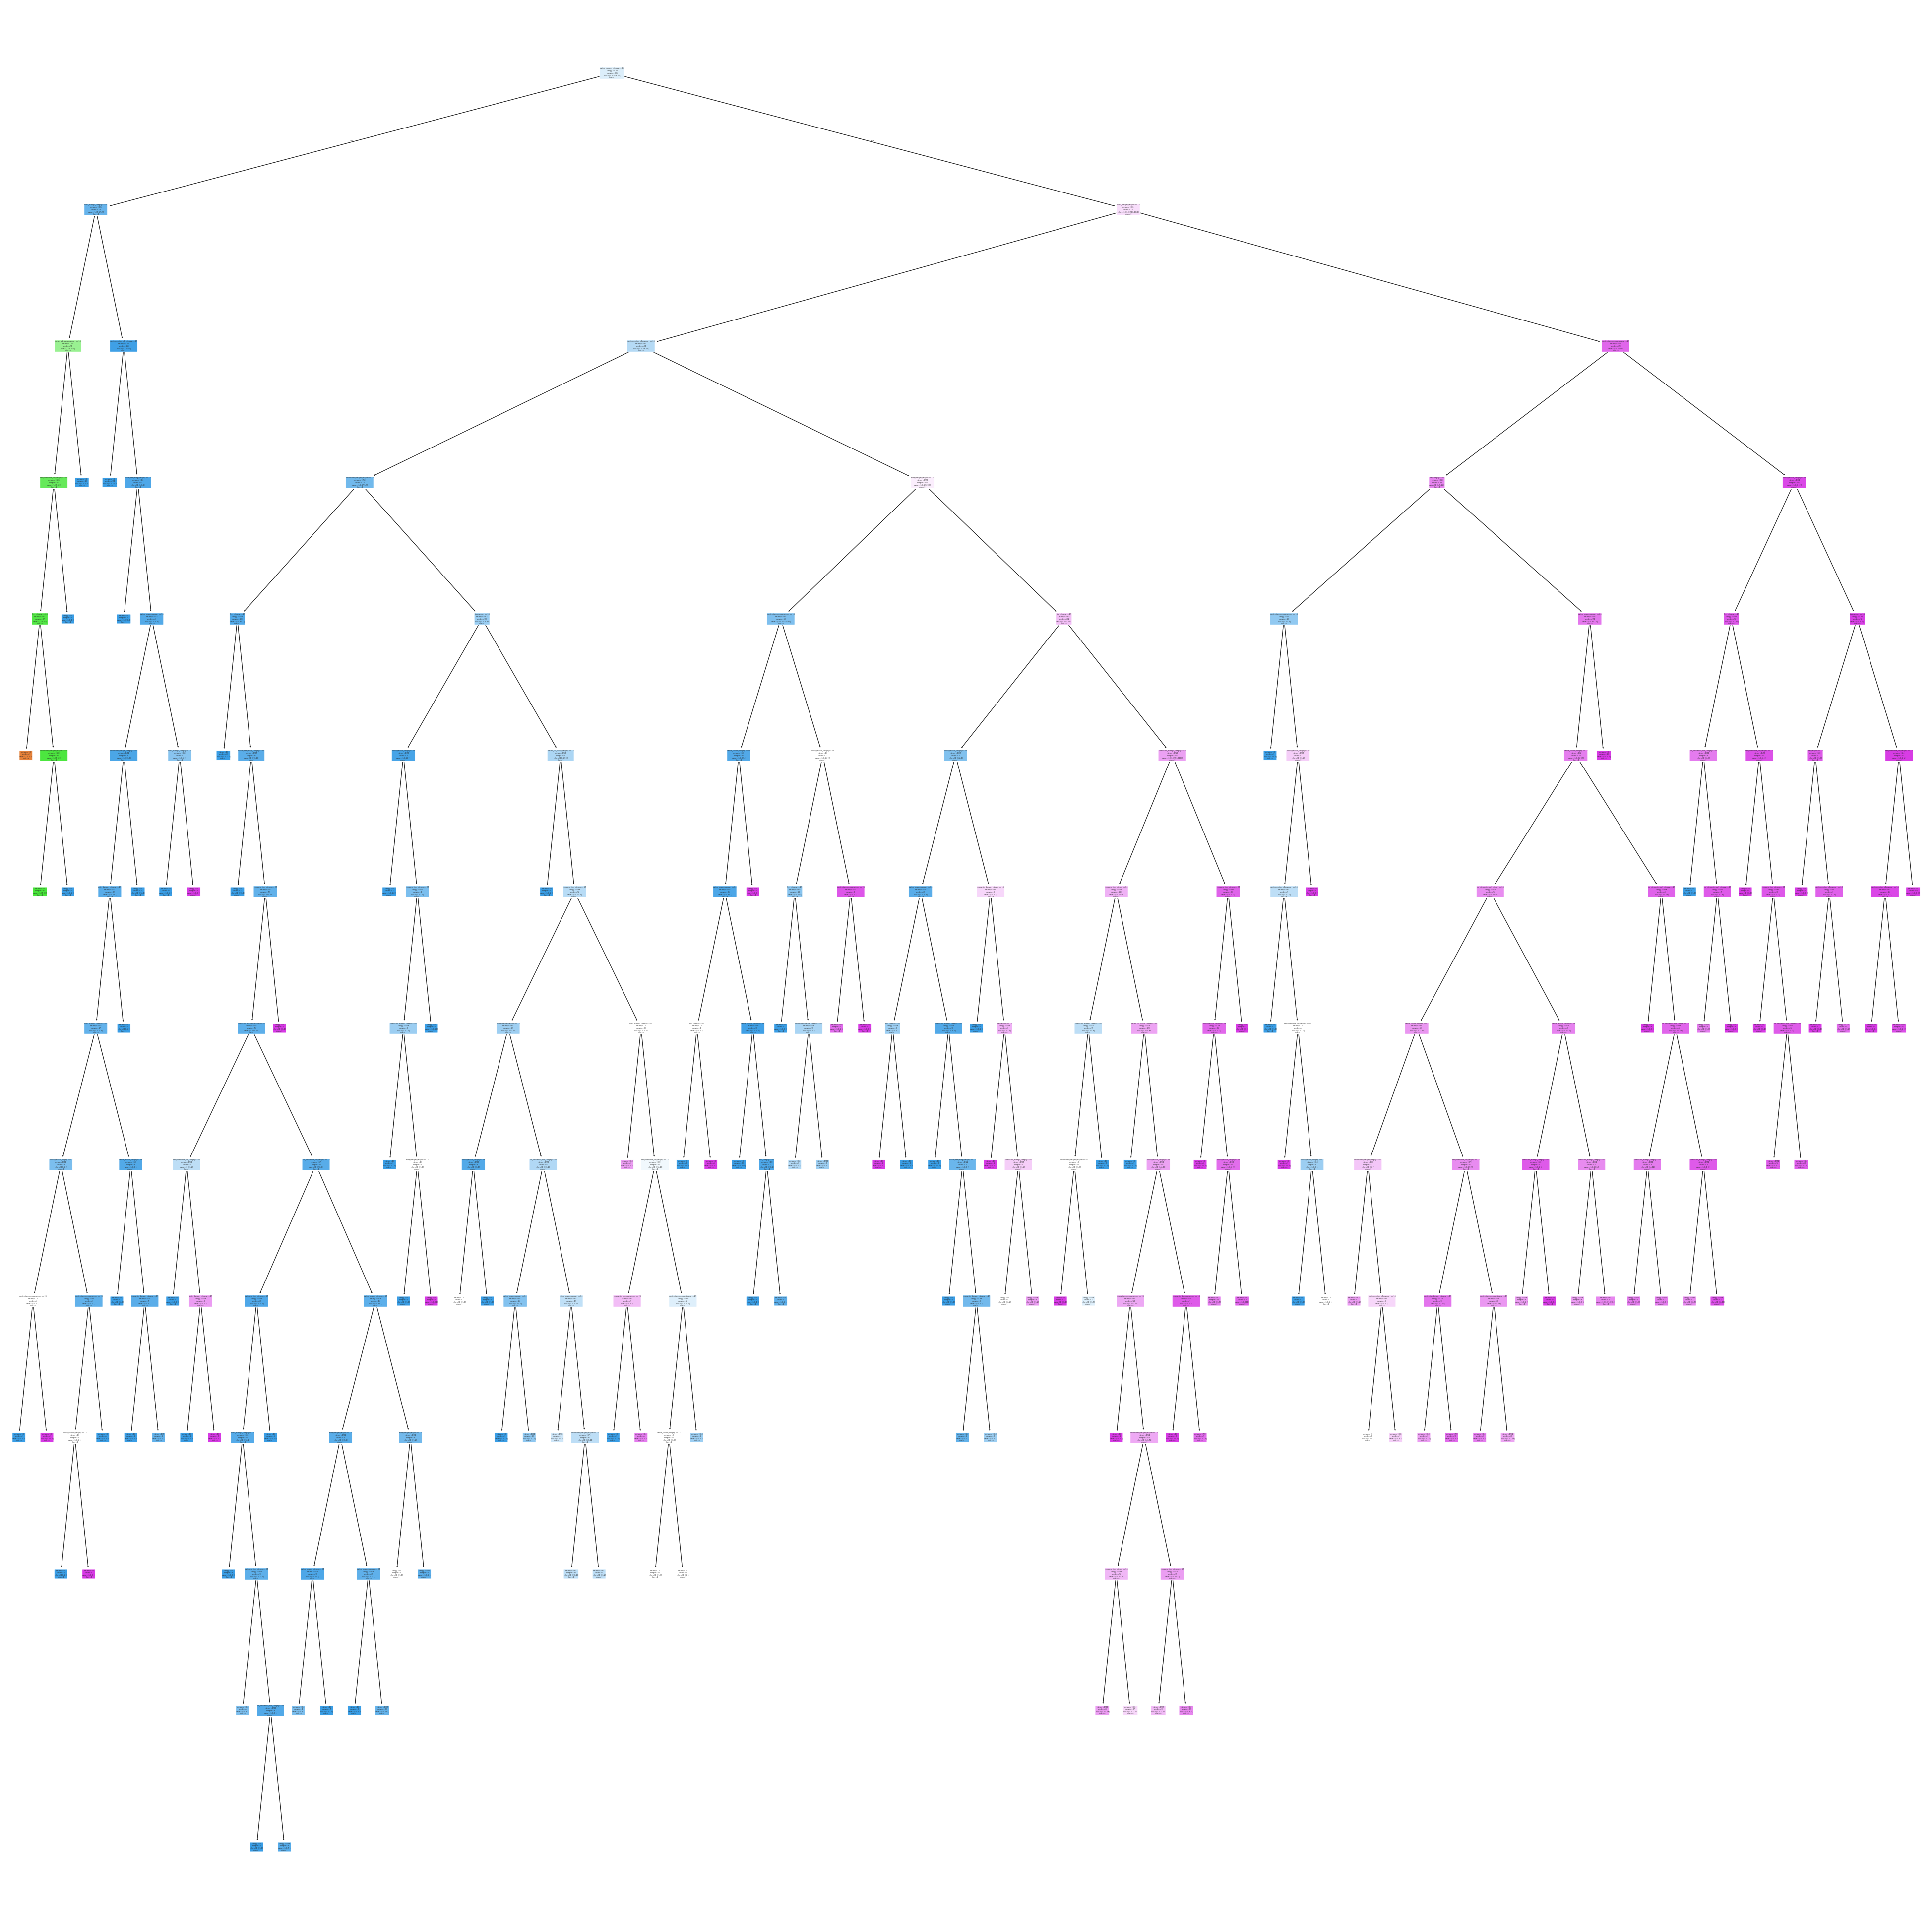

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Graficar el árbol de decisión con Entropía
plt.figure(figsize=(50, 50))
plot_tree(modelo_entropy, feature_names=x_df.columns, class_names=y_df.unique().astype(str), filled=True, rounded=True)
plt.show()



In [ ]:
y_pred_entropy = modelo_entropy.predict(X_test_df)

In [ ]:
print("Resultados con Entropía:")
print(classification_report(y_test_df, y_pred_entropy))
print("Exactitud:", accuracy_score(y_test_df, y_pred_entropy))
error= 1 - accuracy_score(y_test_df, y_pred_entropy)
print("error:", error)

Resultados con Entropía:
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.79      0.75      0.77       217
           3       0.74      0.78      0.76       196

    accuracy                           0.77       423
   macro avg       0.78      0.81      0.79       423
weighted avg       0.77      0.77      0.77       423

Exactitud: 0.7659574468085106
error: 0.23404255319148937


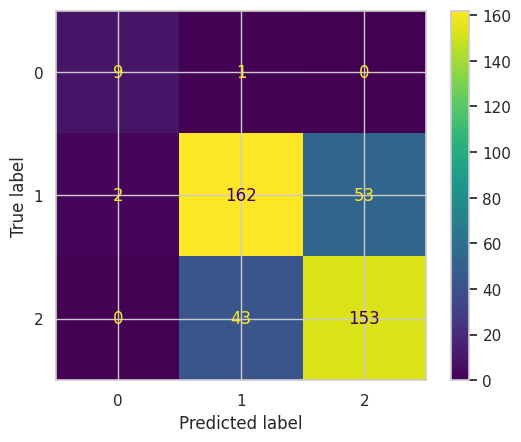

In [ ]:
cm = confusion_matrix(y_test_df, y_pred_entropy)

ConfusionMatrixDisplay(cm).plot()

####2.2.2. GINI

In [ ]:
modelo_gini = DecisionTreeClassifier(criterion="gini",splitter = 'best',random_state=125)
modelo_gini.fit(X_train_df, y_train_df)

DecisionTreeClassifier(random_state=125)

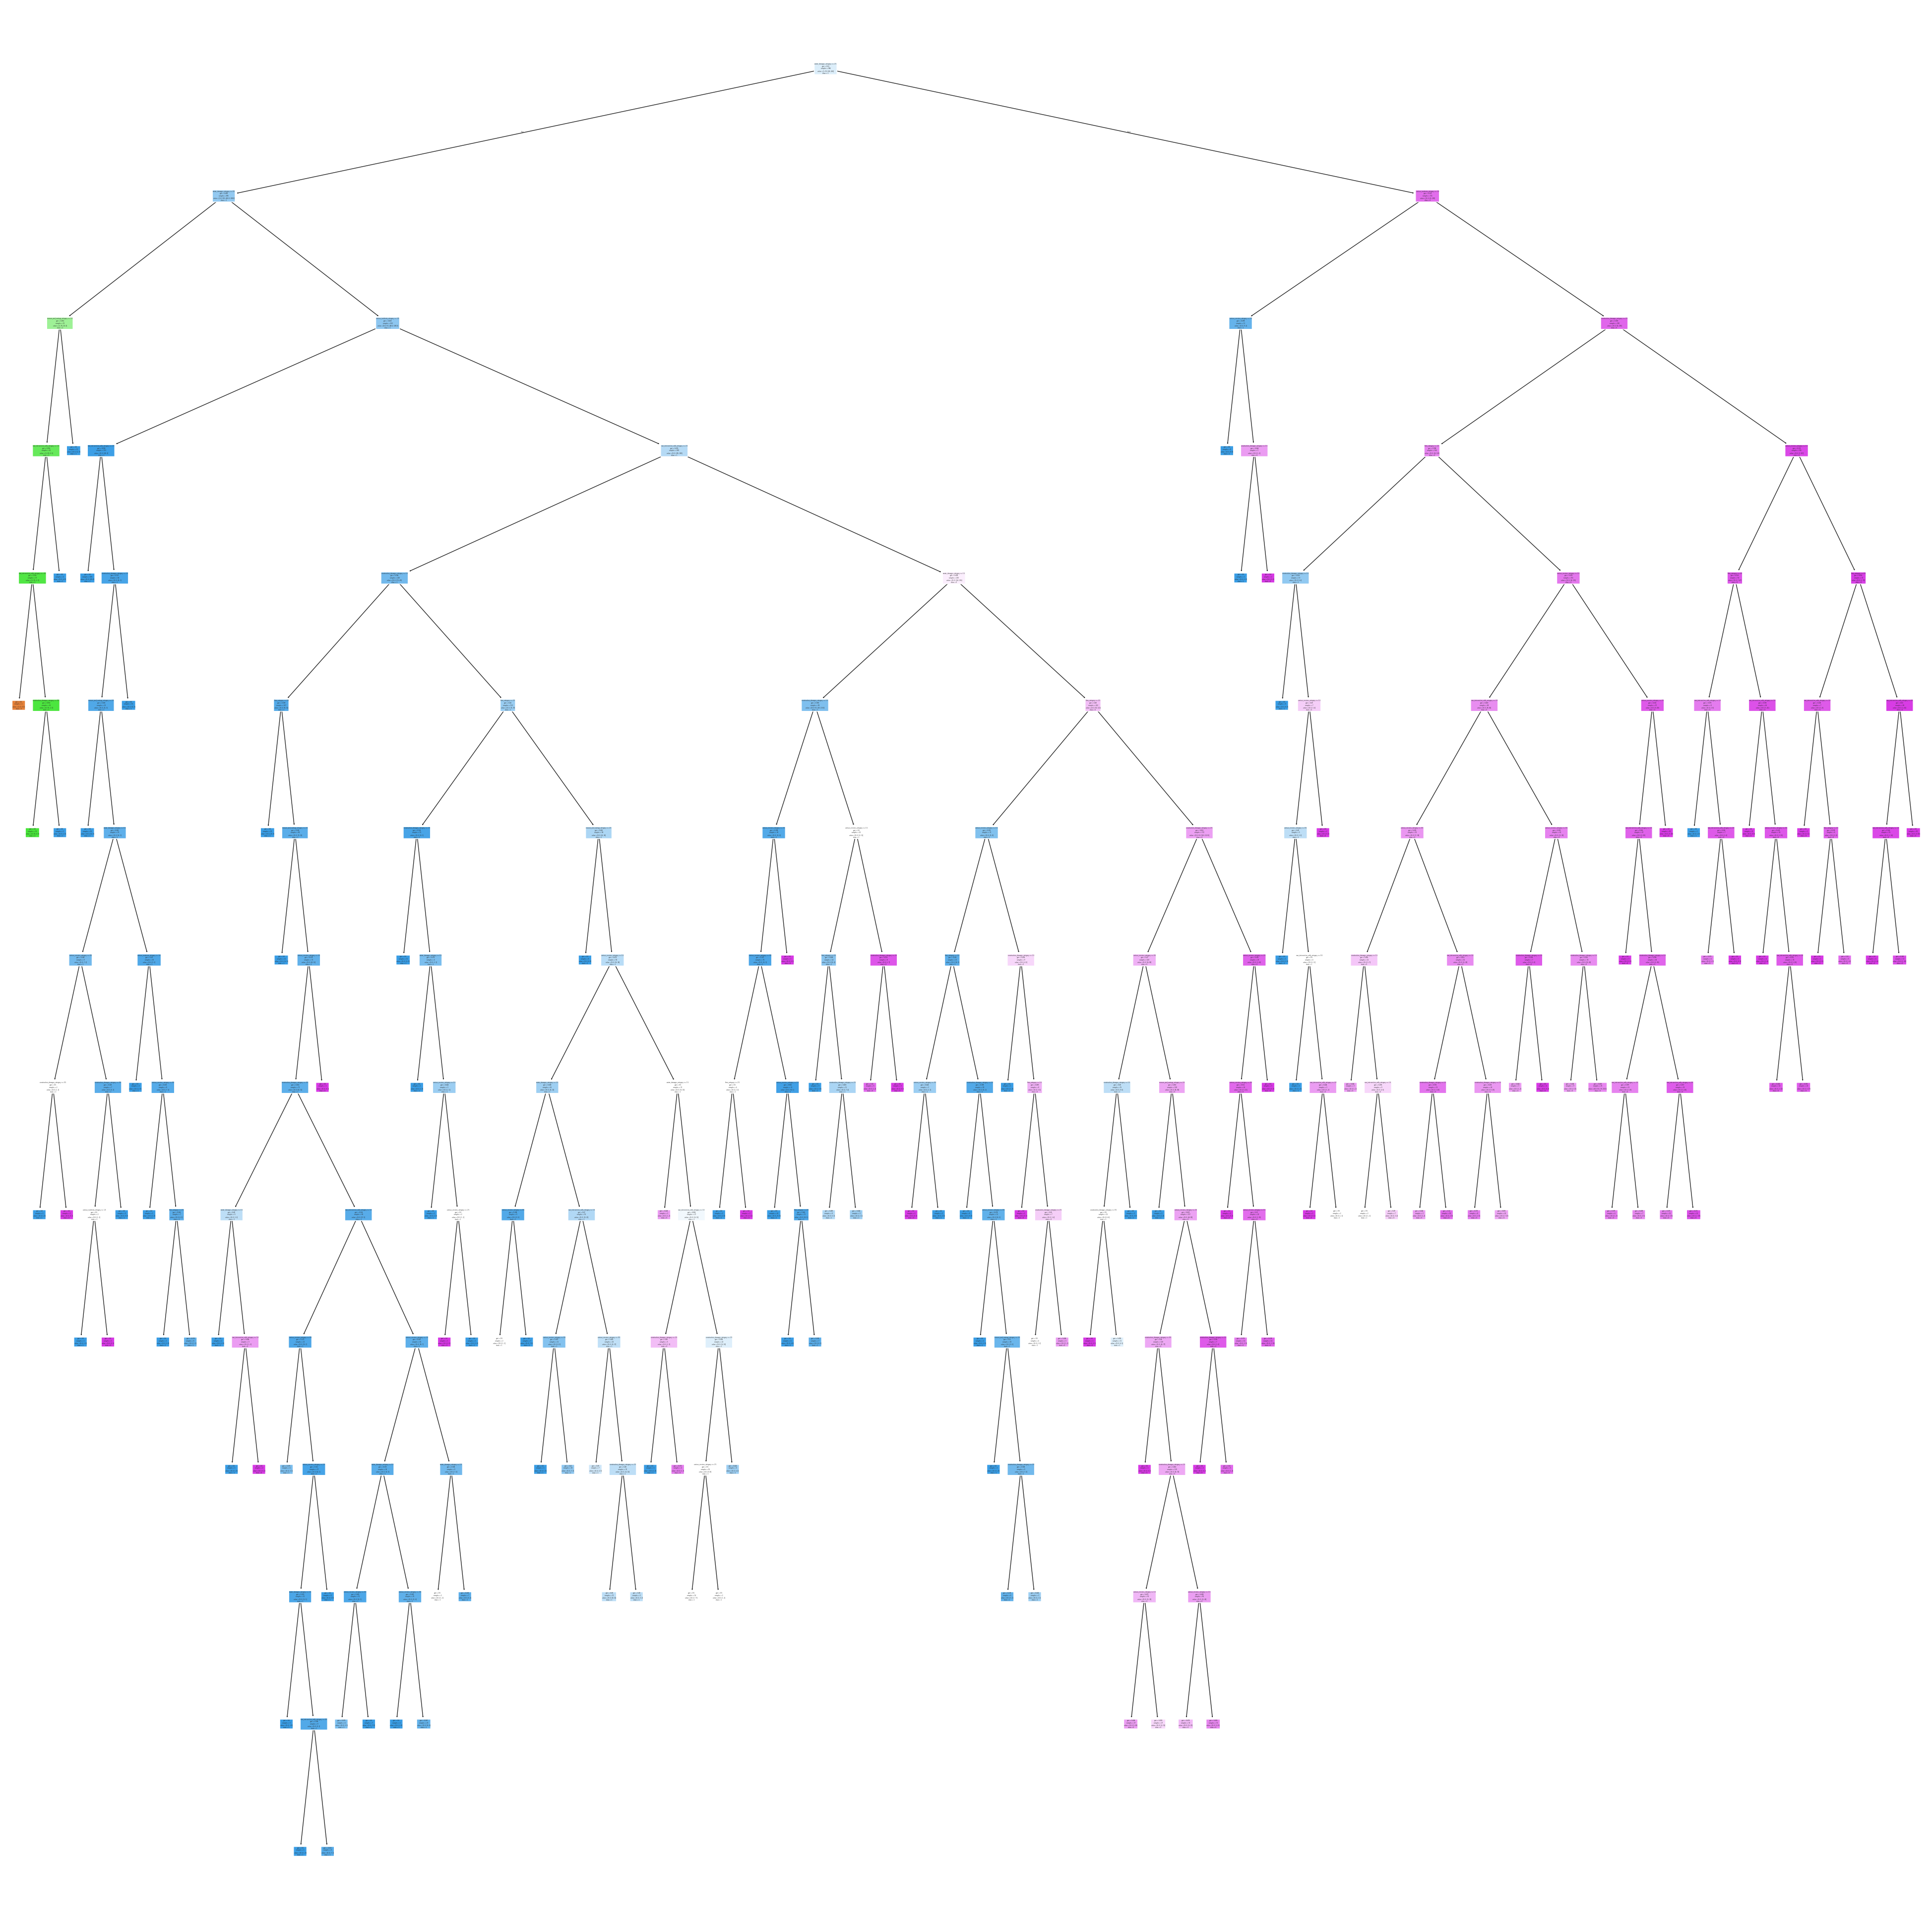

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Graficar el árbol de decisión con Entropía
plt.figure(figsize=(50, 50))
plot_tree(modelo_gini, feature_names=x_df.columns, class_names=y_df.unique().astype(str), filled=True, rounded=True)
plt.show()

In [ ]:

y_pred_gini = modelo_gini.predict(X_test_df)

In [ ]:
print("\nResultados con Gini:")
print(classification_report(y_test_df, y_pred_gini))
print("Exactitud:", accuracy_score(y_test_df, y_pred_gini))
error= 1 - accuracy_score(y_test_df, y_pred_gini)
print("error:", error)


Resultados con Gini:
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.79      0.75      0.77       217
           3       0.74      0.78      0.76       196

    accuracy                           0.77       423
   macro avg       0.78      0.81      0.79       423
weighted avg       0.77      0.77      0.77       423

Exactitud: 0.7659574468085106
error: 0.23404255319148937


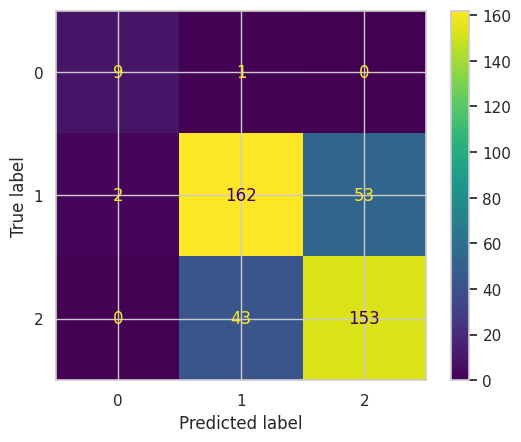

In [ ]:
cm = confusion_matrix(y_test_df, y_pred_gini)

ConfusionMatrixDisplay(cm).plot()

 ####2.2.3. RANDOM FOREST

In [ ]:
!pip install ydata-profiling

In [ ]:
!pip install category_encoders

In [ ]:
from pandas_profiling import ProfileReport
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
sns.set(style='whitegrid', context='notebook')

In [ ]:
#Creo el random forest, n_estimators es el número de árboles de decisión que lo van a formar
rfc_df = RandomForestClassifier(n_estimators=21,random_state=45)

In [ ]:
#Entreno con los datos de entrenamiento
rfc_df.fit(X_train_df,y_train_df)

RandomForestClassifier(n_estimators=21, random_state=45)

In [ ]:
#Hago predicciones sobre test y train
y_pred_test_rf = rfc_df.predict(X_test_df)
y_pred_train_rf = rfc_df.predict(X_train_df)

In [ ]:
#Calculo la matriz de confusión sobre los datos de test
cm = confusion_matrix(y_test_df, y_pred_test_rf)

<Axes: >

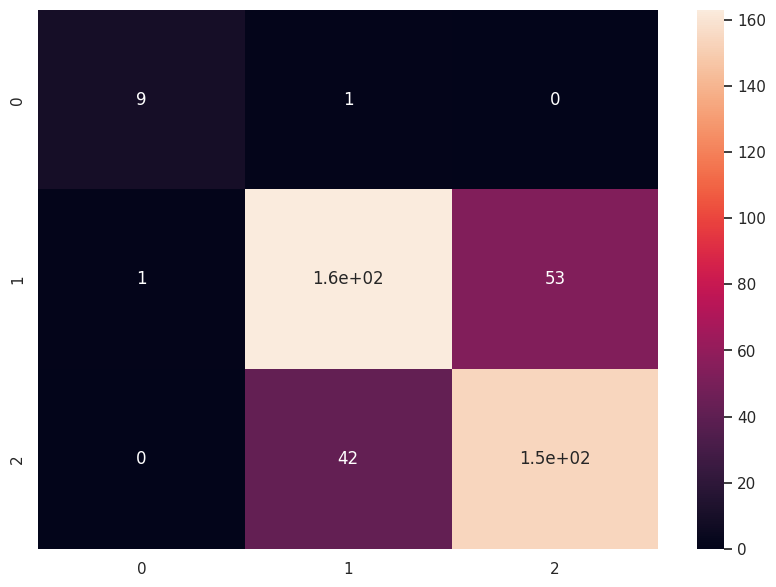

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test_df,y_pred_test_rf))
print("Exactitud:", accuracy_score(y_test_df, y_pred_test_rf))
error= 1 - accuracy_score(y_test_df, y_pred_test_rf)
print("error:", error)

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        10
           2       0.79      0.75      0.77       217
           3       0.74      0.79      0.76       196

    accuracy                           0.77       423
   macro avg       0.81      0.81      0.81       423
weighted avg       0.77      0.77      0.77       423

Exactitud: 0.7706855791962175
error: 0.2293144208037825


<Figure size 5000x5000 with 0 Axes>

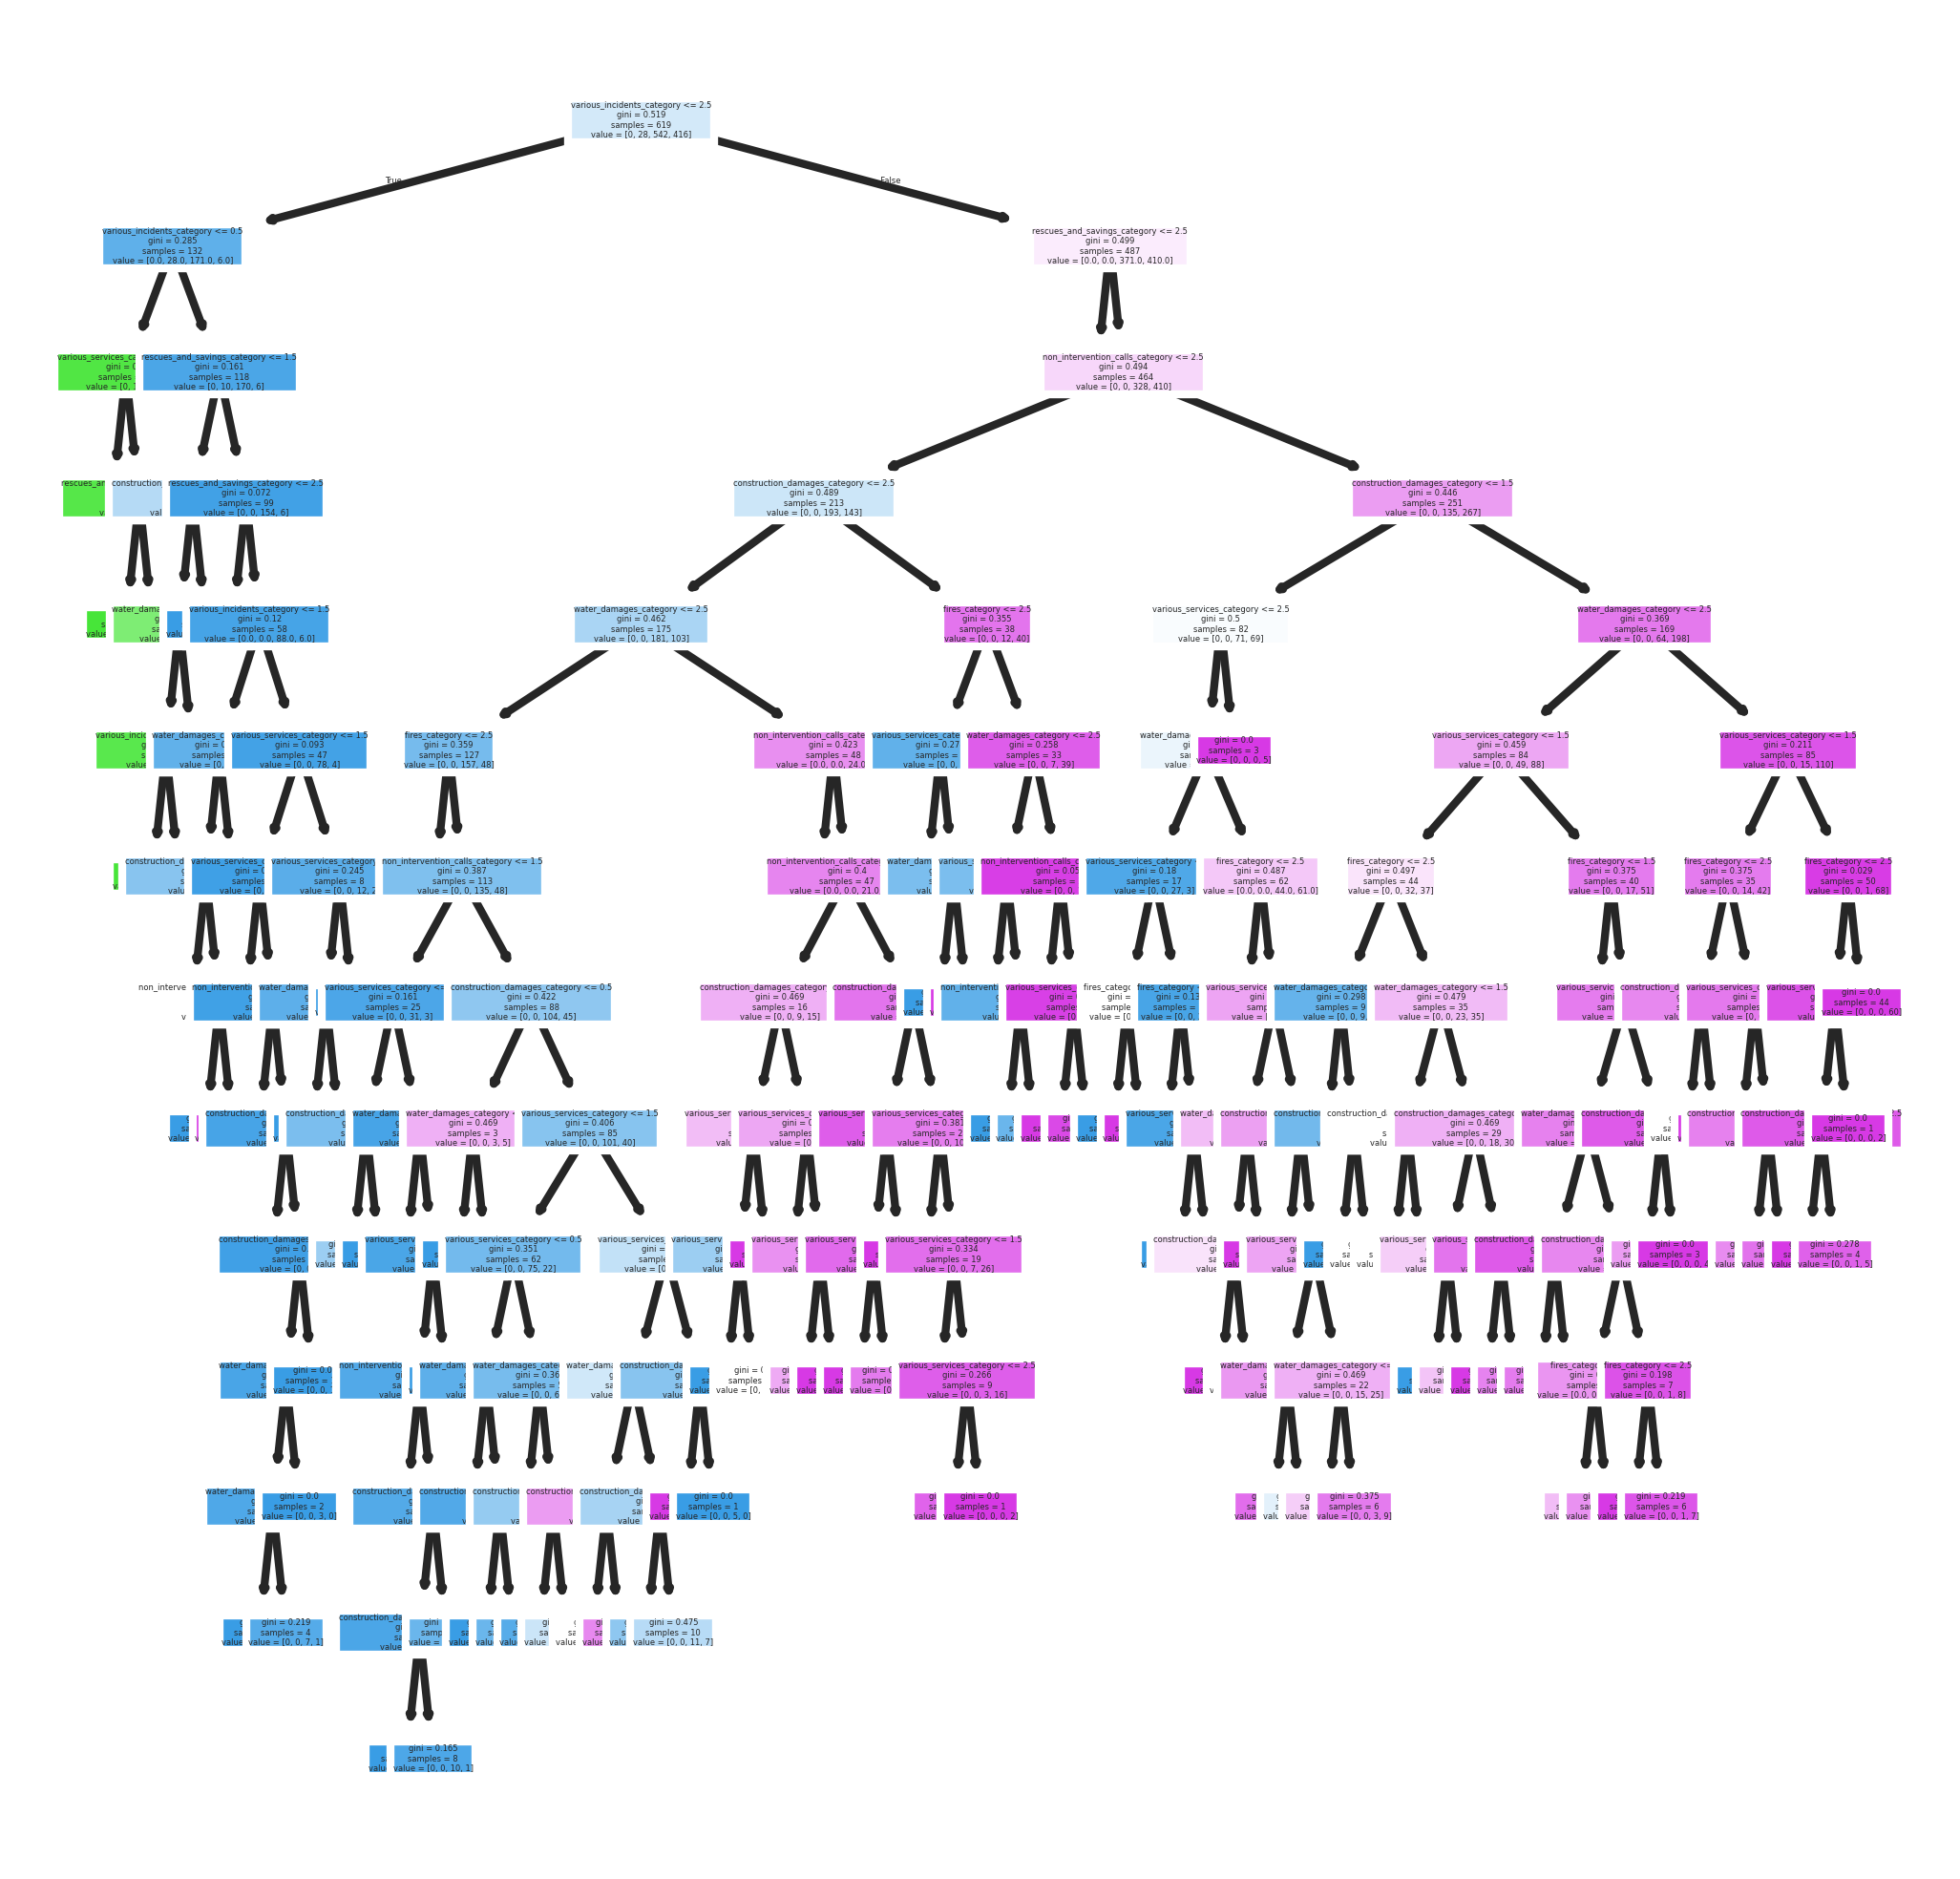

In [ ]:
plt.figure(figsize=(50, 50))

tree_index = 0
Tree = rfc_df.estimators_[tree_index]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(Tree, feature_names=X_train_df.columns, filled=True)
plt.savefig('tree.png')

###PREDECIR

In [ ]:
nuevas_instancias = pd.DataFrame([
    [0, 1, 0, 2, 1, 0, 3],
    [-5, 6, -7, -8, -9, -6, -5],
    [12, 2, 14, 15, 1, 11, 7],
    [0, 7, 3, 12, 8, 2, 14],
    [-20, -18, -25, -22, -30, -19, -24]
], columns=X_train_df.columns)


In [ ]:
predicciones_rf = rfc_df.predict(nuevas_instancias)

print("\nClases predichas para las nuevas instancias:", predicciones_rf)


Clases predichas para las nuevas instancias: [2 2 3 3 0]


###Si el modelo obtenido para extraer las reglas es demasiado grande, repite el proceso de entrenamiento con el 10% de los datos.

In [ ]:
from sklearn.model_selection import train_test_split

X_train_pequeño, _, y_train_pequeño, _ = train_test_split(X_train_df, y_train_df, train_size=0.1, random_state=42)

rfc_df.fit(X_train_pequeño, y_train_pequeño)


RandomForestClassifier(n_estimators=21, random_state=45)

<Figure size 5000x5000 with 0 Axes>

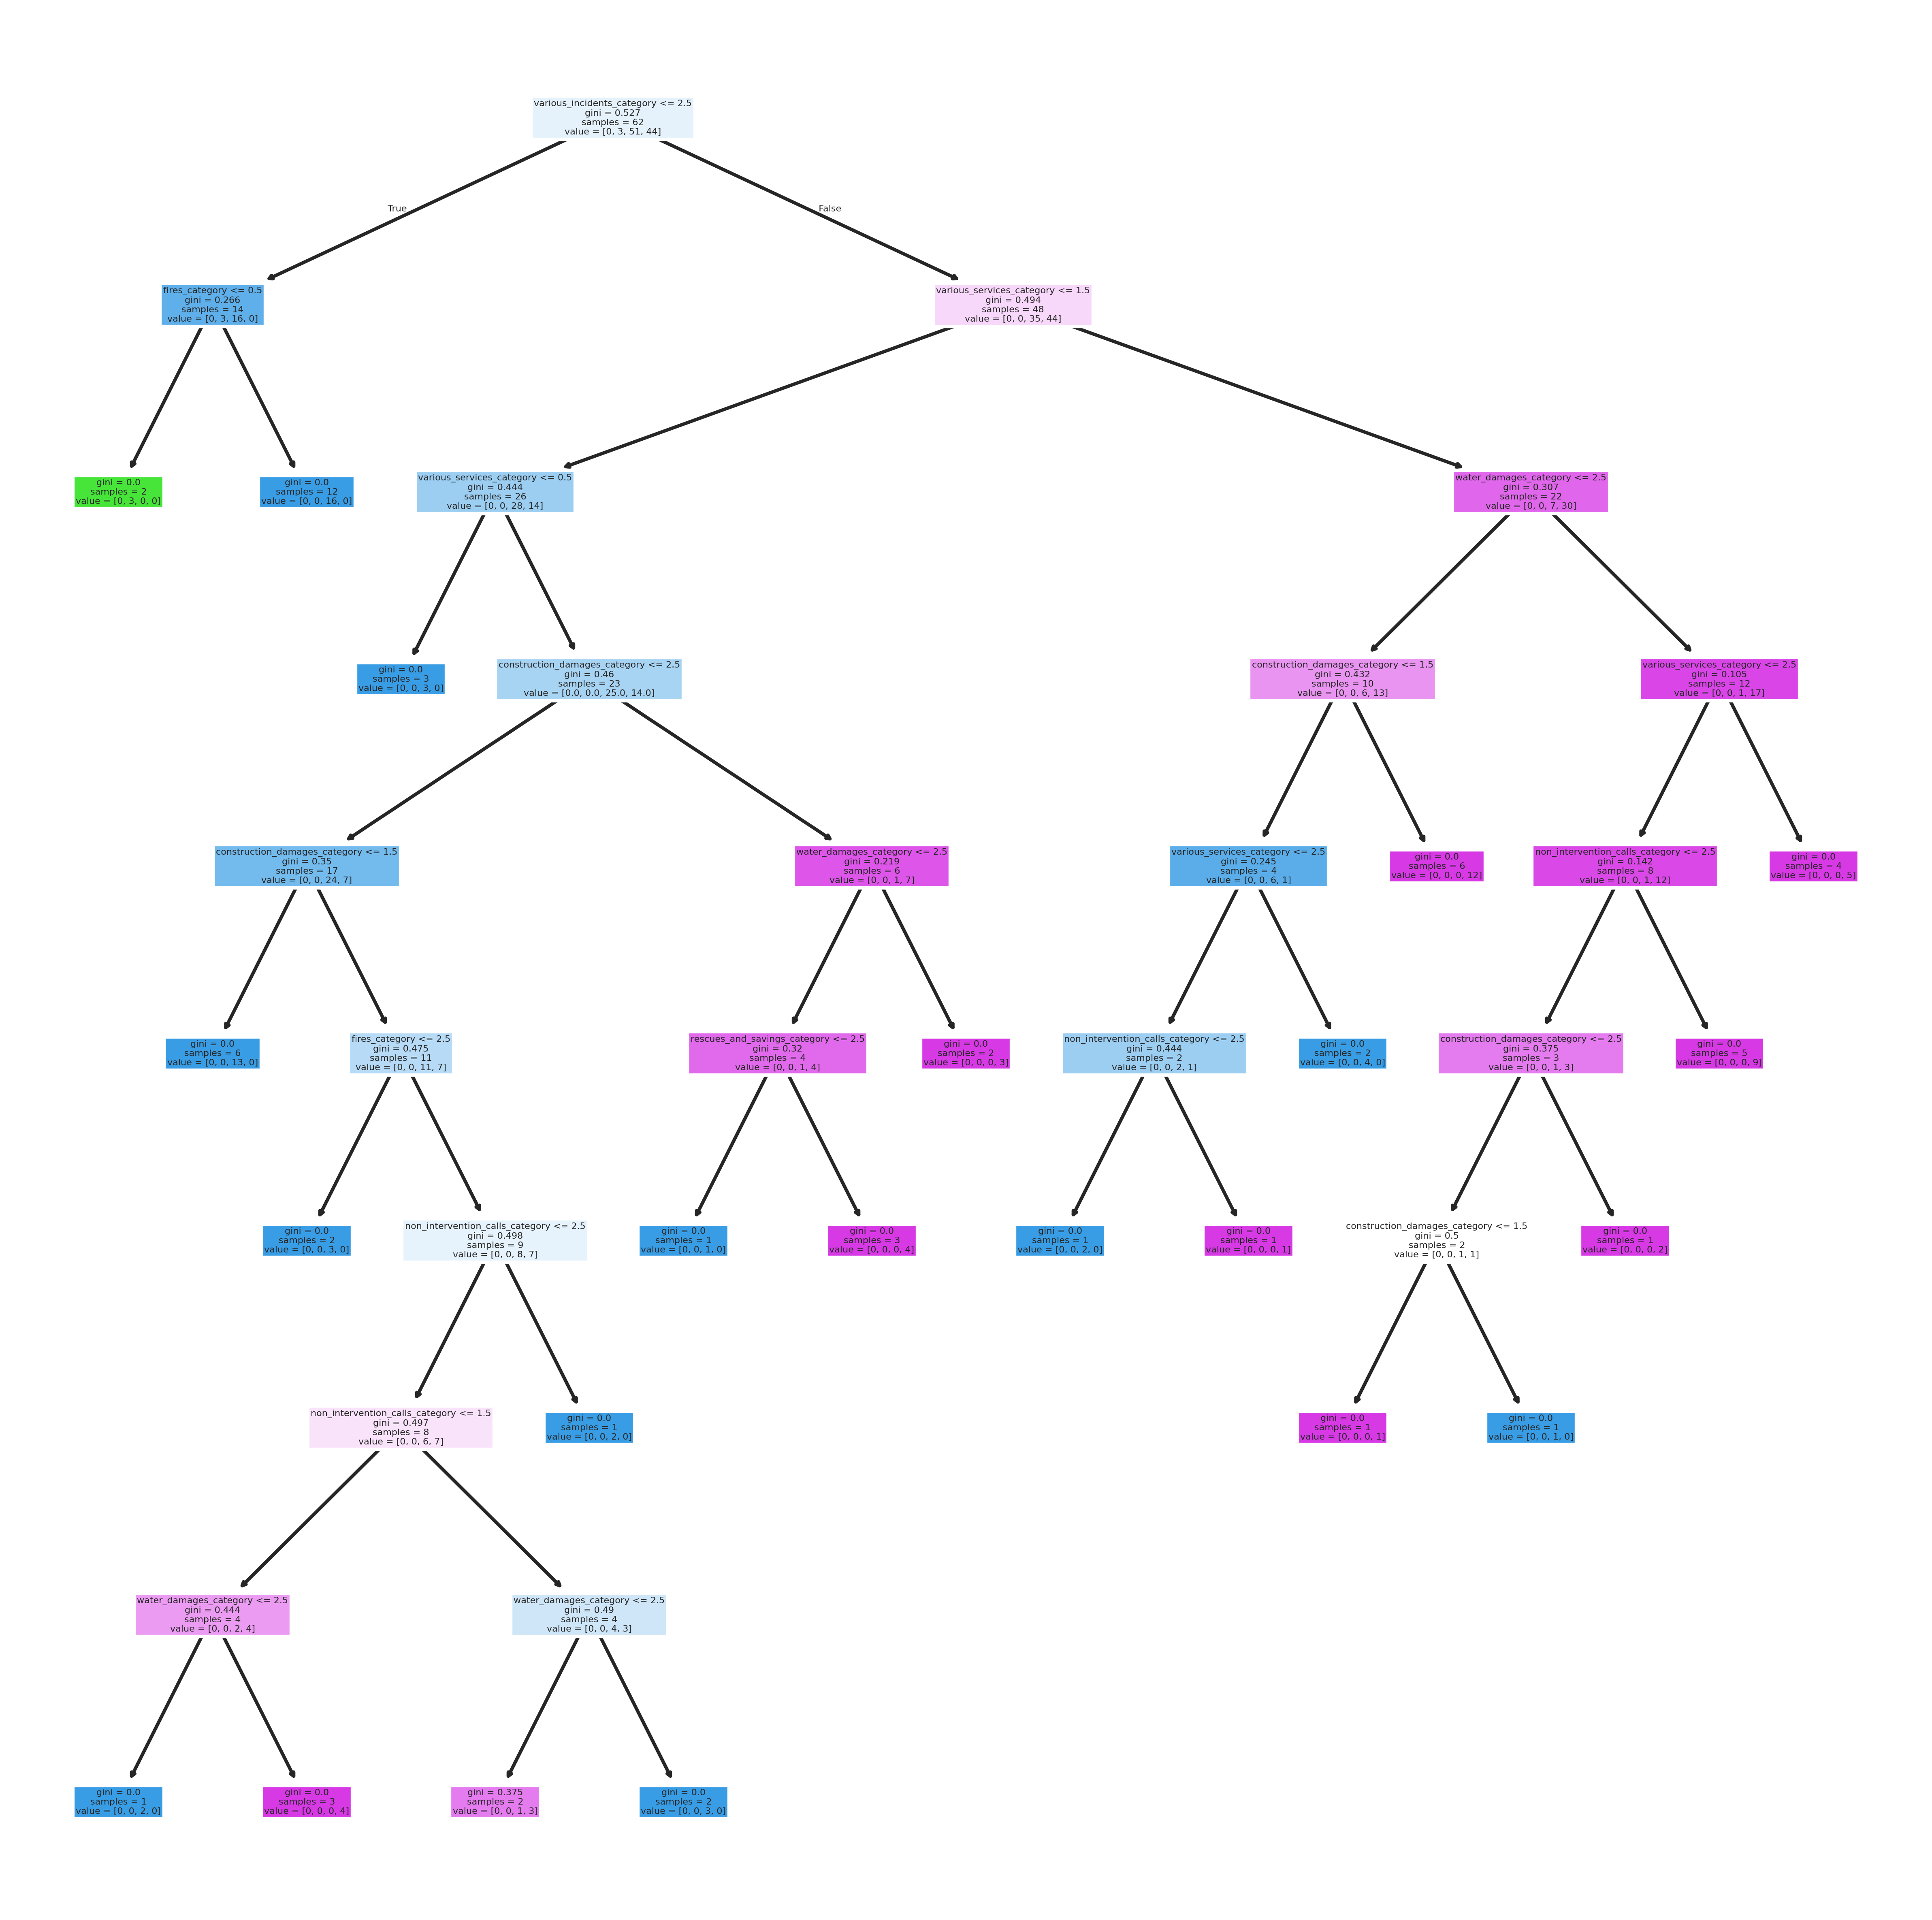

In [ ]:
tree_index = 0
Tree = rfc_df.estimators_[tree_index]

plt.figure(figsize=(50, 50))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=600)
plot_tree(Tree, feature_names=X_train_df.columns, filled=True, ax=ax)


plt.savefig('tree_pequeño.png')
plt.show()

CLASIFICACIÓN NUEVAS INSTANCIAS CON EL MEJOR MODELO

In [3]:
import pandas as pd

# Cargar el archivo CSV con separador ';'
file_path = "/content/firefighters_operations_madrid.csv"
data = pd.read_csv(file_path, sep=';')

# Mostrar las primeras filas para confirmar la lectura
data.head()


,year,month,district,fires,construction_damages,rescues_and_savings,water_damages,various_incidents,non_intervention_calls,various_services,risk
0,2017,Agosto,CENTRO,47,20,44,26,34,19,9,199.0
1,2017,Agosto,ARGANZUELA,24,5,20,15,28,13,3,108.0
2,2017,Agosto,RETIRO,11,7,12,9,30,3,1,73.0
3,2017,Agosto,SALAMANCA,19,12,20,17,32,4,1,105.0
4,2017,Agosto,CHAMARTIN,15,6,21,8,34,11,2,97.0


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- Paso 1: Preprocesamiento como ya se hizo en la práctica ---

# Eliminar duplicados por año, mes, distrito
data.drop_duplicates(subset=["year", "month", "district"], keep='first', inplace=True)

# Eliminar filas con riesgo nulo (riesgo faltante)
data.dropna(subset=['risk'], inplace=True)

# Reemplazar nombres de meses por su versión estandarizada
data['month'].replace(
    ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
    inplace=True
)

# Función para categorizar los valores numéricos
def categorize_column(column, none_max, low_max, medium_max):
    categories = []
    for value in column:
        if value <= none_max:
            categories.append('None_' + column.name)
        elif value <= low_max:
            categories.append('Low_' + column.name)
        elif value <= medium_max:
            categories.append('Medium_' + column.name)
        else:
            categories.append('High_' + column.name)
    return categories

# Aplicar a todas las columnas relevantes
data["fires_category"] = categorize_column(data["fires"], 0, 4, 10)
data["construction_damages_category"] = categorize_column(data["construction_damages"], 0, 4, 10)
data["rescues_and_savings_category"] = categorize_column(data["rescues_and_savings"], 0, 4, 10)
data["water_damages_category"] = categorize_column(data["water_damages"], 0, 4, 10)
data["various_incidents_category"] = categorize_column(data["various_incidents"], 0, 4, 10)
data["non_intervention_calls_category"] = categorize_column(data["non_intervention_calls"], 0, 4, 10)
data["various_services_category"] = categorize_column(data["various_services"], 0, 4, 10)
data["risk_category"] = categorize_column(data["risk"], 0, 10, 100)

# Codificación numérica para el modelo
cat_map = {
    'None': 0, 'Low': 1, 'Medium': 2, 'High': 3
}

for col in ['fires_category', 'construction_damages_category', 'rescues_and_savings_category',
            'water_damages_category', 'various_incidents_category', 'non_intervention_calls_category',
            'various_services_category', 'risk_category']:
    data[col] = data[col].str.extract(r'(None|Low|Medium|High)')[0].map(cat_map)

# Variables predictoras y variable objetivo
X = data[[
    "fires_category", "construction_damages_category", "rescues_and_savings_category",
    "water_damages_category", "various_incidents_category", "non_intervention_calls_category",
    "various_services_category"
]]
y = data["risk_category"]

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Paso 2: Modelo Random Forest ---

model_rf = RandomForestClassifier(n_estimators=25, random_state=42)
model_rf.fit(X_train, y_train)

# --- Paso 3: Clasificar 5 nuevas instancias ---

nuevas_instancias = pd.DataFrame([
    [0, 1, 0, 2, 1, 0, 3],   # mezcla baja y alta
    [2, 3, 2, 3, 2, 2, 2],   # todo medio/alto
    [0, 0, 0, 0, 0, 0, 0],   # todo bajo
    [3, 3, 3, 3, 3, 3, 3],   # todo alto
    [1, 2, 1, 1, 2, 1, 1]    # combinación típica
], columns=X.columns)

predicciones = model_rf.predict(nuevas_instancias)

# Evaluación general del modelo
y_pred_test = model_rf.predict(X_test)
exactitud = accuracy_score(y_test, y_pred_test)
reporte = classification_report(y_test, y_pred_test, output_dict=True)

(predicciones, exactitud, reporte)


<ipython-input-4-d42457e5e557>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['month'].replace(


(array([2, 2, 1, 3, 2]),
 0.7825059101654847,
 {'1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
  '2': {'precision': 0.8019323671497585,
   'recall': 0.7649769585253456,
   'f1-score': 0.7830188679245284,
   'support': 217.0},
  '3': {'precision': 0.7524271844660194,
   'recall': 0.7908163265306123,
   'f1-score': 0.7711442786069652,
   'support': 196.0},
  'accuracy': 0.7825059101654847,
  'macro avg': {'precision': 0.8514531838719259,
   'recall': 0.8519310950186526,
   'f1-score': 0.8513877155104979,
   'support': 423.0},
  'weighted avg': {'precision': 0.7836762454535162,
   'recall': 0.7825059101654847,
   'f1-score': 0.7826462717413424,
   'support': 423.0}})